In [110]:
import wandb, json
import pandas as pd
import numpy as np
import os
import matplotlib.ticker as ticker

os.environ["WANDB_SILENT"] = "true"
entity_name = "louis-jalouzot"
project_name = "fMRI-Decoding-wrap-up"
api = wandb.Api(
    timeout=100, overrides={"project": project_name, "entity": entity_name}
)
global_run = wandb.init()
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")

# Utils

In [111]:
def fetch_artifact(name, split, fold):
    artifact = f"louis-jalouzot/fMRI-Decoding-wrap-up/run-{name}-"
    if fold is not None:
        artifact += f"fold_{fold}"
    artifact += f"{split}metrics:latest"
    artifact = global_run.use_artifact(artifact, type="run_table")
    artifact_dir = artifact.download()
    if fold is not None:
        artifact_dir += f"/fold_{fold}"
    artifact_dir += f"/{split}/metrics.table.json"
    with open(artifact_dir) as f:
        metrics = json.load(f)

    return metrics


def load_split_folds(name, splits="test", n_folds=15):
    df = []
    if isinstance(splits, str):
        splits = [splits]
    if n_folds is not None:
        total = n_folds * len(splits)
    else:
        total = len(splits)

    with tqdm(total=total) as pbar:
        for split in splits:
            if n_folds is not None:
                for fold in range(1, n_folds + 1):
                    metrics = fetch_artifact(name, split, fold)
                    df.append(
                        pd.DataFrame(
                            metrics["data"], columns=metrics["columns"]
                        )
                    )
                    pbar.update(1)
            else:
                metrics = fetch_artifact(name, split, None)
                df.append(
                    pd.DataFrame(metrics["data"], columns=metrics["columns"])
                )
                pbar.update(1)

    return pd.concat(df)

# Example

In [ ]:
sns.lineplot(x=[0, 1, 2], y=[1, 2, 0])
plt.title("Line")
sns.despine(offset=10, trim=True)
# plt.tight_layout()
plt.savefig("paper/figs/test.svg")

# Decoding performance

## Setup

In [90]:
df = []
runs = api.runs(filters={"tags": {"$in": ["setup_v2"]}})
for run in tqdm(runs):
    if run._state == "finished":
        run_data = run.config | run.summary._json_dict
        df.append(pd.json_normalize(run_data))
df = pd.concat(df)

  0%|          | 0/48 [00:00<?, ?it/s]

In [154]:
baseline = load_split_folds(
    name="33582f283c354ab9f545ab5c4cd8866fc46b8fc6",
    splits=["train", "valid", "test"],
    n_folds=None,
)  # random baseline
baseline = baseline.drop_duplicates(["run", "tr"]).groupby("run").top_10_accuracy.mean().reset_index(name="Top 10 Accuracy")
baseline["Setup"] = "Random"

  0%|          | 0/3 [00:00<?, ?it/s]

In [114]:
df["model"] = df["latents_cfg.model"].replace({"bert-base-uncased": "BERT", "McGill-NLP/LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse": "LLM2Vec"})
df["n_voxels"] = df["top_encoding_voxels"]
df.loc[~df.n_voxels.isna(), "n_voxels"] = "4096 voxels"
df.loc[df.n_voxels.isna(), "n_voxels"] = "Whole brain"

In [164]:
value_name = "Top 10 Accuracy"
cols = [col for col in df if "top_10_accuracy" in col and "test" in col and "fold" in col and "fmriprep" in col]
tmp = df.melt(id_vars=["model", "decoder_cfg.class", "n_voxels", "wrapper_cfg.loss"], var_name="subject", value_vars=cols, value_name=value_name).dropna()
tmp["subject"] = tmp.subject.str.split("/").apply(lambda x: x[-2]).str.split("_").apply(lambda x: x[-1])

In [181]:
tmp = tmp[tmp.subject == "UTS03"]

In [182]:
classical = tmp["wrapper_cfg.loss"] == "mse"
contrastive = tmp["wrapper_cfg.loss"] == "symm_nce"
mlp = tmp["decoder_cfg.class"] == "SimpleMLP"
brain_decoder = tmp["decoder_cfg.class"] == "BrainDecoder"
bert = tmp["model"] == "BERT"
llm2vec = tmp["model"] == "LLM2Vec"
whole_brain = tmp["n_voxels"] == "Whole brain"
top_voxels = tmp["n_voxels"] == "4096 voxels"

In [183]:
setup_1 = whole_brain * bert * mlp * classical
setup_1 = tmp[setup_1].copy()
setup_1["Setup"] = "Simple MLP"
setup_2 = whole_brain * bert * mlp * contrastive
setup_2 = tmp[setup_2].copy()
setup_2["Setup"] = "Contrastive learning"
setup_3 = whole_brain * bert * brain_decoder * contrastive
setup_3 = tmp[setup_3].copy()
setup_3["Setup"] = "Brain decoder"
setup_4 = whole_brain * llm2vec * brain_decoder * contrastive
setup_4 = tmp[setup_4].copy()
setup_4["Setup"] = "LLM2Vec latents"
setup_5 = top_voxels * llm2vec * brain_decoder * contrastive
setup_5 = tmp[setup_5].copy()
setup_5["Setup"] = "Top 4096 encoding voxels"

In [184]:
setups = pd.concat([baseline, setup_1, setup_2, setup_3, setup_4, setup_5])

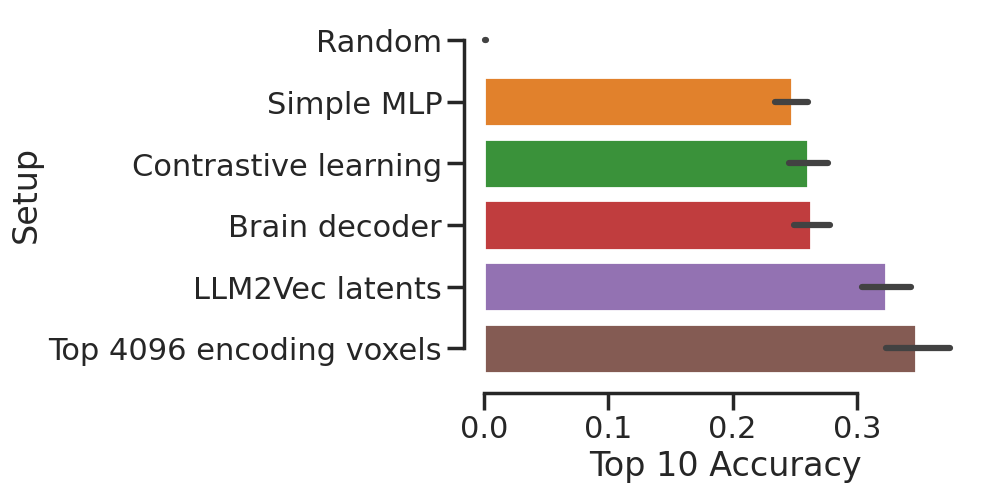

In [186]:
ax = sns.barplot(data=setups, y="Setup", x="Top 10 Accuracy", hue="Setup", legend=None)
ax.set_xlim(-0.005, ax.get_xlim()[1])
sns.despine(offset=10, trim=True)
plt.savefig("paper/figs/setup.svg")

# Syntax/semantics

In [ ]:
baseline = load_split_folds(
    name="33582f283c354ab9f545ab5c4cd8866fc46b8fc6",
    splits=["train", "valid", "test"],
    n_folds=None,
)  # random baseline
df = load_split_folds(
    "b2af211a703e07acc44416e4bafa8c35fb85e65c"
)  # zoom_in_nlp_100
baseline = baseline[["glove_bow_pos_restricted_cosine", "pos_ratio"]].mean()
df[["glove_bow_pos_restricted_cosine", "pos_ratio"]] = (
    df[["glove_bow_pos_restricted_cosine", "pos_ratio"]] - baseline
) / baseline

In [ ]:
sorted_runs = df.groupby("run").top_10_accuracy.mean().sort_values()
best_runs = sorted_runs.iloc[-20:].index
worst_runs = sorted_runs.iloc[:20].index
tmp = (
    df[(df.run.isin(best_runs)) + (df.run.isin(worst_runs))]
    .query("top < 80")
    .copy()
)
tmp["run_type"] = "20 Worst stories"
tmp.loc[tmp.run.isin(best_runs), "run_type"] = "20 Best stories"
tmp = tmp.melt(
    id_vars=["top", "run_type"],
    value_vars=["glove_bow_pos_restricted_cosine", "pos_ratio"],
    var_name="metric",
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
g = sns.FacetGrid(
    tmp,
    palette="tab10",
    row="metric",
    col="run_type",
    sharey=False,
    height=5,
    aspect=1.5,
)
g.map_dataframe(
    sns.barplot,
    x="top",
    y="value",
    hue="run_type",
    palette="tab10",
    hue_order=["20 Best stories", "20 Worst stories"],
    err_kws={"linewidth": 1.5},
    dodge=0,
    edgecolor="none",
    width=1,
)
g.set_titles(template="{col_name}/{row_name}")
for i, ax in enumerate(g.axes.flat):
    run_type, metric = ax.get_title().split("/")
    if ax.get_ylabel():
        if metric == "glove_bow_pos_restricted_cosine":
            ax.set_ylabel("Semantic", labelpad=20)
        elif metric == "pos_ratio":
            ax.set_ylabel("Syntactic", labelpad=20)
    if i // 2 == 0:
        ax.set_title(run_type)
    else:
        ax.set_title("")
    if ax.get_xlabel():
        ax.set_xlabel("Candidate rank", labelpad=20)
    ax.xaxis.set_major_locator(ticker.LinearLocator(9))
sns.despine(offset=20, trim=True)
plt.suptitle("Normalized NLP similarities (ratio above baseline)")
plt.tight_layout()
plt.savefig("paper/figs/nlp_similarities.svg")

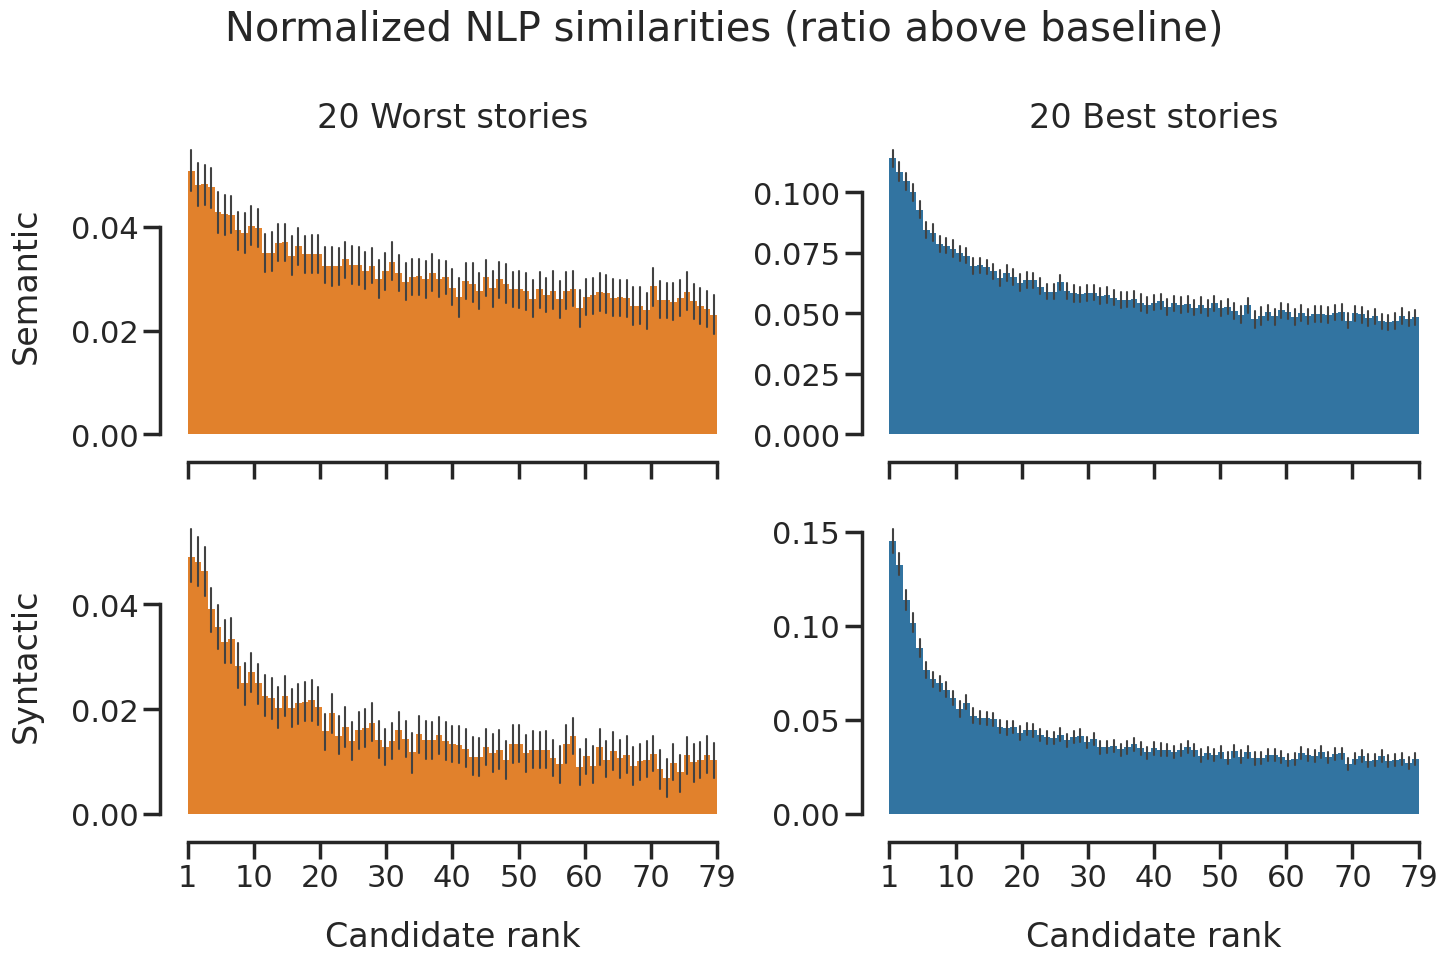

In [143]:
g = sns.FacetGrid(
    tmp,
    palette="tab10",
    row="metric",
    col="run_type",
    sharey=False,
    height=5,
    aspect=1.5,
)
g.map_dataframe(
    sns.barplot,
    x="top",
    y="value",
    hue="run_type",
    palette="tab10",
    hue_order=["20 Best stories", "20 Worst stories"],
    err_kws={"linewidth": 1.5},
    dodge=0,
    edgecolor="none",
    width=1,
)
g.set_titles(template="{col_name}/{row_name}")
for i, ax in enumerate(g.axes.flat):
    run_type, metric = ax.get_title().split("/")
    if ax.get_ylabel():
        if metric == "glove_bow_pos_restricted_cosine":
            ax.set_ylabel("Semantic", labelpad=20)
        elif metric == "pos_ratio":
            ax.set_ylabel("Syntactic", labelpad=20)
    if i // 2 == 0:
        ax.set_title(run_type)
    else:
        ax.set_title("")
    if ax.get_xlabel():
        ax.set_xlabel("Candidate rank", labelpad=20)
    ax.xaxis.set_major_locator(ticker.LinearLocator(9))
sns.despine(offset=20, trim=True)
plt.suptitle("Normalized NLP similarities (ratio above baseline)")
plt.tight_layout()
plt.savefig("paper/figs/nlp_similarities.svg")